* Rename this notebook as PRENOM_NOM_TP_ACTIVE_LEARNING.ipynb
* Delivery deadline is March the 26th

* Load the Digit dataset from [here](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html),
* to renormalize the data, divide by 255,
* create a train and test set: the size of the test set should be 250;
* evaluate the performance of a [Logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) on the data set that you just created. **Remark:** do not change model's hyperparameters.

In [7]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

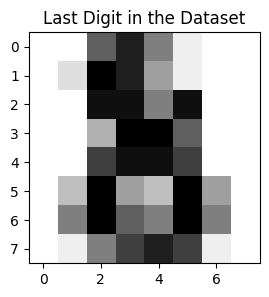

In [8]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def import_digits(test_size=250, show_last_digit=True):
    """
    Charge le dataset digits, normalise les données, divise en ensembles d'entraînement et de test,
    et affiche le dernier chiffre du dataset si demandé.

    Parameters:
    - test_size: int, La taille de l'ensemble de test.
    - show_last_digit: bool, Indique si le dernier chiffre du dataset doit être affiché.

    Returns:
    - x_train: array, Les caractéristiques d'entraînement.
    - x_test: array, Les caractéristiques de test.
    - y_train: array, Les étiquettes d'entraînement.
    - y_test: array, Les étiquettes de test.
    """
    digits = datasets.load_digits()

    # Normalisation des données
    x = digits.data / 255.0
    y = digits.target

    # Affichage du dernier chiffre si demandé
    if show_last_digit:
        plt.figure(figsize=(3, 3))
        plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
        plt.title("Last Digit in the Dataset")
        plt.show()

    # Division en ensembles d'entraînement et de test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=33)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test= import_digits(test_size=250, show_last_digit=True)

In [9]:
# Initialize Logistic Regression model
model = LogisticRegression()


# Train the model
model.fit(x_train, y_train)


# Make predictions on the test set
y_pred = model.predict(x_test)


# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2%}")

Accuracy on the test set: 86.40%


Split the train set above to create a pool set and a train set; the size of the new train set should be 200. **Remark:** if you use Scikit Learn's function train_test_split, do not use the option 'stratify'. At the end of this stage you should have obtained three data sets: a train set, a test set and a pool set.

In [10]:
from sklearn.model_selection import train_test_split

def split_data_sets(x_train, y_train, x_test, train_size, random_state=33):
    """
    Divise l'ensemble d'entraînement original pour créer un nouvel ensemble d'entraînement et un ensemble pool,
    puis imprime les tailles de l'ensemble d'entraînement nouvellement créé, de l'ensemble pool et de l'ensemble de test.
    
    """
    # Division de l'ensemble d'entraînement original
    x_pool, x_train_new, y_pool, y_train_new = train_test_split(x_train, y_train, test_size=train_size, random_state=random_state)
    
    # Affichage des tailles des ensembles
    print(f"Size of the new train set: {len(x_train_new)}")
    print(f"Size of the pool set: {len(x_pool)}")
    print(f"Size of the test set: {len(x_test)}")
    
    return x_pool, x_train_new, y_pool, y_train_new

# Exemple d'utilisation de la fonction
x_pool, x_train_new, y_pool, y_train_new = split_data_sets(x_train, y_train, x_test, train_size=200)


Size of the new train set: 200
Size of the pool set: 1347
Size of the test set: 250


The goal of this exercice is to implement the following learning algorithms:


1.   Random sampling,
2.   Active learning "least confidence" query strategy,
3.   Active learning "entropy" query strategy.

and to plot, for each of them, the learning curve, having the model accuracy and the iteration number on the y and x axis respectively.

The general form of these algorithms, written in pseudo-code, is given here below:

**input:** x_train, x_test, y_train, y_test, x_pool, y_pool, max_number_iterations,

**output** score_list, a list containing model's accuracy for each iteration.
```
for i < max_number_iterations:
  initialize a Logistic regression classifier clf
  learn clf on x_train, y_train
  get clf score on x_test, y_test
  append score to score_list
  *query an instance and its label from x_pool, y_pool
  append the queried instance and its label to x_train, y_train
  delete the queried instance and its label from x_pool, y_pool

```
where the line starting with * should be replaced by algorithms 1. 2. and 3. above. The parameter max_number_iterations can be set equal to 400.

You will find here below some hints to implement the three algorithms:

**Random sampling**: in this case you can just
* sample a random row from x_pool,
* get the corresponding label from y_pool,

In [11]:
def random_sampling(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations):
    score_list = []

    for i in range(max_iterations):
        clf = LogisticRegression()
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_test)
        uncertainty = np.random.rand(len(x_pool))  

        index = np.argmax(uncertainty)
        x_selected, y_selected = x_pool[index], y_pool[index]

        x_train = np.vstack([x_train, x_selected])
        y_train = np.append(y_train, y_selected)

        x_pool = np.delete(x_pool, index, axis=0)
        y_pool = np.delete(y_pool, index)

        score = accuracy_score(clf.predict(x_test), y_test)
        score_list.append(score)

    return score_list

**Least confidence**:
* get the predicted probability distribution y_prob for each sample in x_pool (by using clf.predict_proba() )
* compute the maximum probability max_proba of the matrix y_prob along each row (by using numpy.amax())
* get the vector of least confidence by doing 1 - max_proba
* by using numpy.argmax(), select the index associated with the sample which has least confidence,
* get the corresponding label from y_pool.

In [12]:
def least_confidence(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations):
    score_list = []

    for i in range(max_iterations):
        clf = LogisticRegression()
        clf.fit(x_train, y_train)

        y_pred_prob = clf.predict_proba(x_pool)
        uncertainty = 1 - np.max(y_pred_prob, axis=1)  # Least confidence

        selected_index = np.argmax(uncertainty)
        x_selected, y_selected = x_pool[selected_index], y_pool[selected_index]

        x_train = np.vstack([x_train, x_selected])
        y_train = np.append(y_train, y_selected)

        x_pool = np.delete(x_pool, selected_index, axis=0)
        y_pool = np.delete(y_pool, selected_index)

        score = accuracy_score(y_test, clf.predict(x_test)) # Correction ici
        score_list.append(score)

    return score_list


**Entropy**:
* get the predicted probability distribution y_prob for each sample in x_pool (by using clf.predict_proba(),
* compute the entropy along each row by using the formula (-y_prob * np.log2(y_prob)).sum(axis=1),
* by using numpy.argmax(), select the index of the row with maximum entropy,
* get the corresponding label from y_pool.

In [13]:
def entropy(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations):
    score_list = []

    for i in range(max_iterations):
        clf = LogisticRegression()
        clf.fit(x_train, y_train)

        y_pred_prob = clf.predict_proba(x_pool)
        # Calcul de l'entropie
        uncertainty = -np.sum(y_pred_prob * np.log(y_pred_prob + np.finfo(float).eps), axis=1)  # Ajout de eps pour la stabilité numérique

        selected_index = np.argmax(uncertainty)
        x_selected, y_selected = x_pool[selected_index], y_pool[selected_index]

        x_train = np.vstack([x_train, x_selected])
        y_train = np.append(y_train, y_selected)

        x_pool = np.delete(x_pool, selected_index, axis=0)
        y_pool = np.delete(y_pool, selected_index)

        score = accuracy_score(y_test, clf.predict(x_test))
        score_list.append(score)

    return score_list


For each of the three sampling strategies, make a plot displaying iteration (x axis) vs accuracy (y axis) and comment the results.

For each of the sampling strategies, compute the first iteration for which the model accuracy is larger than 0.8

Commenter le comportement des 3 algos lorsqu'on fait varier la taille de jeu de train et le nombre d'itérations 

In [14]:
def evaluate_learning(train_size, max_iterations):
    # Chargement et préparation des données digits
    x_train, x_test, y_train, y_test = import_digits(test_size=250, show_last_digit=False)
    # Division de l'ensemble d'entraînement en nouvel ensemble d'entraînement et ensemble pool
    x_pool, x_train, y_pool, y_train = split_data_sets(x_train, y_train, x_test, train_size=train_size)
    
    # Application des stratégies d'apprentissage actif et récupération des scores
    random_scores = random_sampling(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations)
    least_conf_scores = least_confidence(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations=max_iterations)
    entropy_scores = entropy(x_pool, y_pool, x_train, y_train, x_test, y_test, max_iterations=max_iterations)
    
    # Visualisation des résultats
    plt.figure(figsize=(8, 6))
    plt.plot(random_scores, label='Random Sampling', color='blue')
    plt.plot(least_conf_scores, label='Least Confidence', color='green')
    plt.plot(entropy_scores, label='Entropy', color='red')
    plt.title('Accuracy of Active Learning Strategies over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.text(0, np.mean(np.array(entropy_scores)), f"Training size: {train_size}", fontsize=9, rotation=90)
    plt.legend()
    plt.show()


#### Manipulant le nombre d'itérations et observant les résultats 

Size of the new train set: 200
Size of the pool set: 1347
Size of the test set: 250


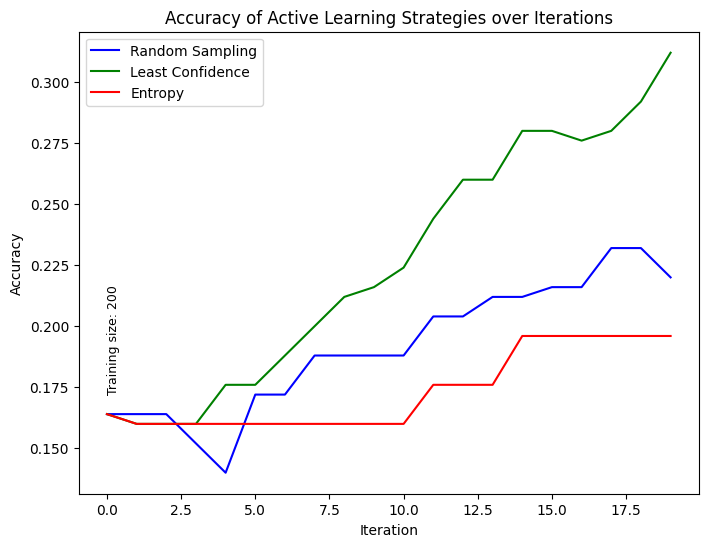

Size of the new train set: 200
Size of the pool set: 1347
Size of the test set: 250


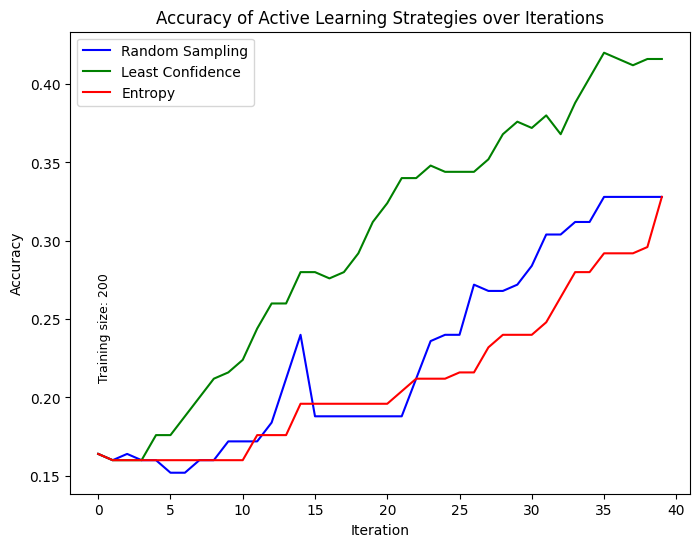

Size of the new train set: 200
Size of the pool set: 1347
Size of the test set: 250


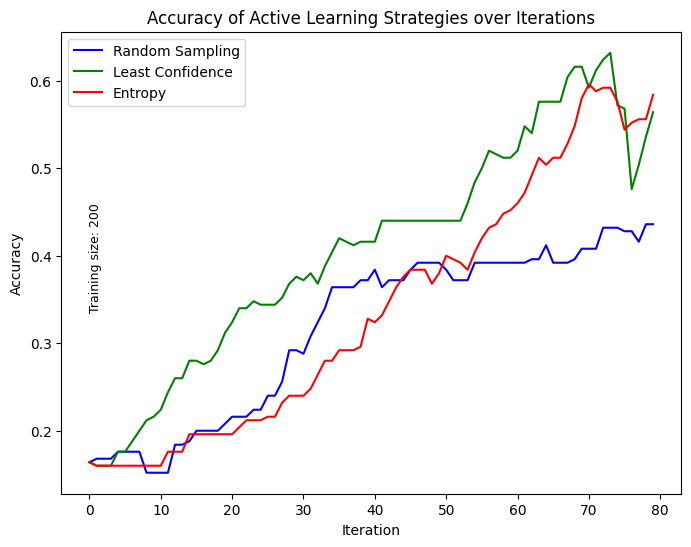

Size of the new train set: 200
Size of the pool set: 1347
Size of the test set: 250


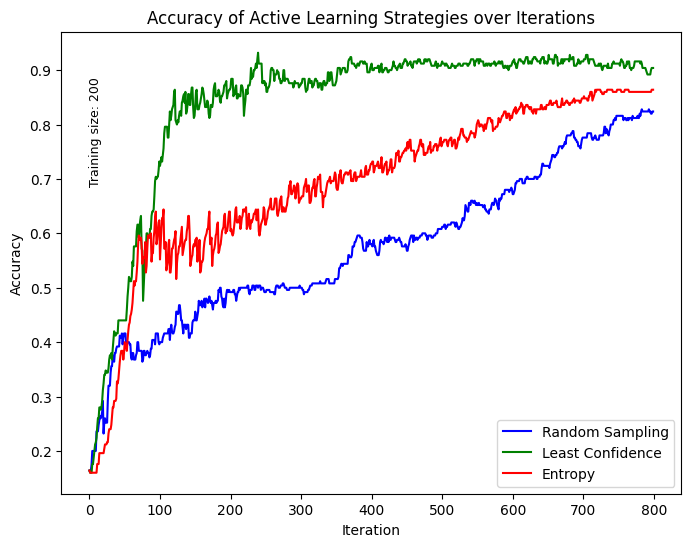

In [15]:
# Exécution de la fonction principale avec les paramètres désirés
evaluate_learning(train_size=200, max_iterations=20)
evaluate_learning(train_size=200, max_iterations=40)
evaluate_learning(train_size=200, max_iterations=80)
evaluate_learning(train_size=200, max_iterations=800)

##### Commentaire
Avec l'augmentation des itérations, l'entropie se montre plus performante, soulignant l'avantage d'une sélection stratégique des données, tandis que les approches de confiance minimale et d'échantillonnage aléatoire montrent des progrès plus modérés.

##### Manipulant maintenant la taille de l'échantillon d'entrainement 

Size of the new train set: 40
Size of the pool set: 1507
Size of the test set: 250


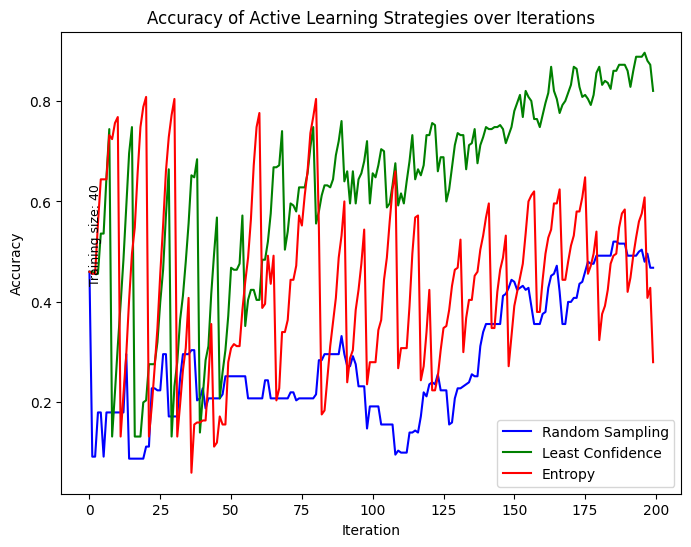

Size of the new train set: 100
Size of the pool set: 1447
Size of the test set: 250


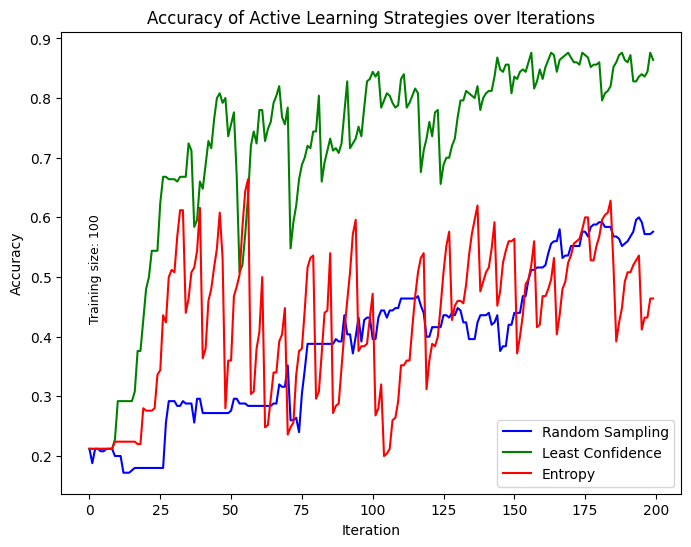

Size of the new train set: 300
Size of the pool set: 1247
Size of the test set: 250


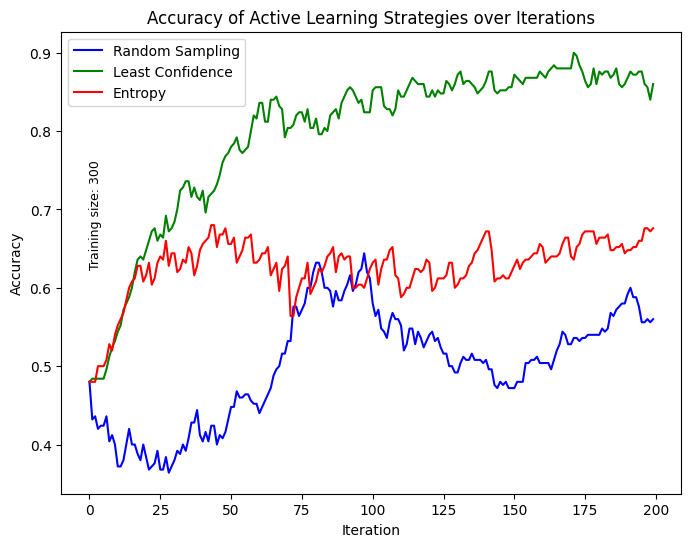

Size of the new train set: 1000
Size of the pool set: 547
Size of the test set: 250


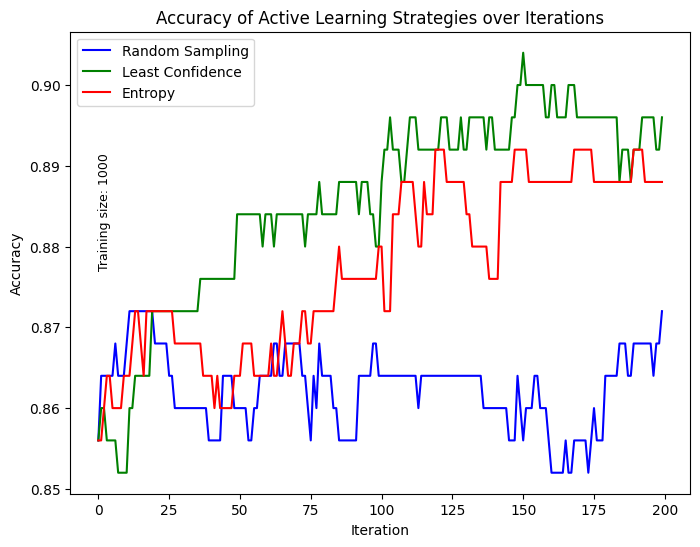

In [16]:
evaluate_learning(train_size=40, max_iterations=200)
evaluate_learning(train_size=100, max_iterations=200)
evaluate_learning(train_size=300, max_iterations=200)
evaluate_learning(train_size=1000, max_iterations=200)

##### Commentaire
En observant les graphiques et en augmentant la taille du train set, on remarque que :

    L'échantillonnage aléatoire montre une légère amélioration de la précision.
    L'entropie gagne en efficacité de manière plus marquée.
    Least confidence démontre la plus forte progression, affirmant son avantage à grande échelle.


Dans l'ensemble, tandis que toutes les stratégies bénéficient d'une augmentation de la taille des données, la stratégie de LEAST confidence se distingue comme étant la plus robuste et efficace, exploitant au mieux l'information supplémentaire fournie par un plus grand nombre d'échantillons.